In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os


/home/mikelin/anaconda3/envs/voice/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/mikelin/anaconda3/envs/voice/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [3]:
import glob
test_data = []
test_labels = []
'''load testing data'''
test_folder = "./inference_clips_sample/"
positive_example_folder = test_folder+"is_breath_0"
positive_example_list = sorted(glob.glob(positive_example_folder+"/*"))

negative_example_folder = test_folder+"is_breath_1"
negative_example_list = sorted(glob.glob(negative_example_folder+"/*"))

for f in positive_example_list:
    wav, sr = librosa.load(f, sr=None)
    print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
    test_data.append(spec_to_image(get_melspectrogram_db(f))[np.newaxis,...])
    test_labels.append(0)

for f in negative_example_list:
    wav, sr = librosa.load(f, sr=None)
    print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
    test_data.append(spec_to_image(get_melspectrogram_db(f))[np.newaxis,...])
    test_labels.append(1)

print(test_labels)

Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
[0, 0, 0, 1, 1, 1]


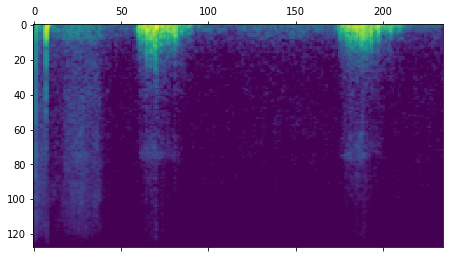

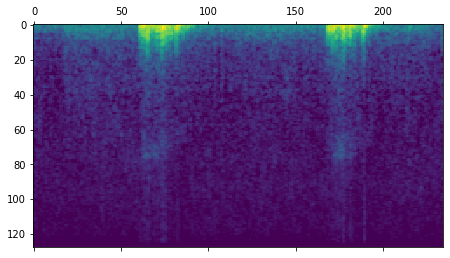

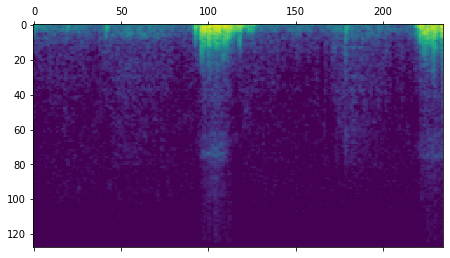

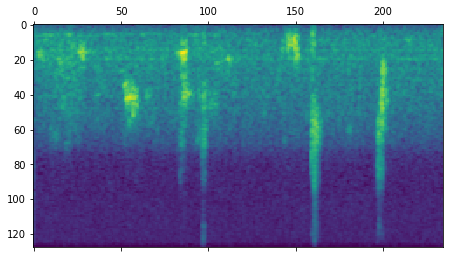

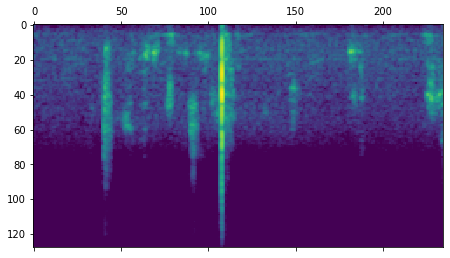

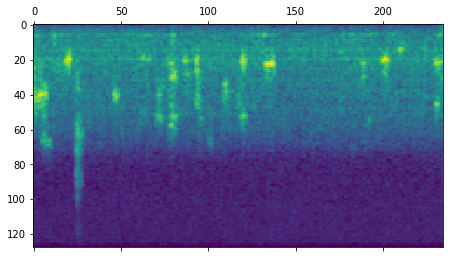

In [4]:
for i in range(len(test_data)):
    plt.matshow(test_data[i][0])
    plt.show()

In [5]:
if torch.cuda.is_available():
  device=torch.device('cuda:7')
else:
  device=torch.device('cpu')


# '''define_model'''
# from torchvision.models import resnet34
# resnet_model = resnet34(pretrained=True)
# resnet_model.fc = nn.Linear(512,2)
# resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet_model = resnet_model.to(device)



In [38]:
for param_tensor in resnet_model.state_dict():
    print(param_tensor, "\t", resnet_model.state_dict()[param_tensor].size())


conv1.weight 	 torch.Size([64, 1, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batches_tracked 	 torch.

In [8]:
PATH = 'trained_models/breath_resnet.pth'

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

resnet_model = load_checkpoint(PATH)
print(resnet_model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for i, _ in enumerate(test_data):
    spec_t=torch.tensor(test_data[i][0]).to(device, dtype=torch.float32)
    pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
    ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
    print(ind)

0
0
0
1
1
1


In [23]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

if torch.cuda.is_available():
  device=torch.device('cuda:7')
else:
  device=torch.device('cpu')


class IsBreathInference():
    def __init__(self, model_path):
        
        def load_checkpoint(filepath):
            checkpoint = torch.load(filepath)
            model = checkpoint['model']
            model.load_state_dict(checkpoint['state_dict'])
            for parameter in model.parameters():
                parameter.requires_grad = False
            model.eval()
            print(model)
            return model
        
        self.model = load_checkpoint(model_path)
        
    
    def spec_to_image(self, spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    def get_melspectrogram_db(self, file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
        wav,sr = librosa.load(file_path,sr=sr)
        if wav.shape[0]<5*sr:
            wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
        else:
            wav=wav[:5*sr]
            spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                      hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
            spec_db=librosa.power_to_db(spec,top_db=top_db)
        return spec_db
    
    
    def load_data(self, inputs_path):
        test_data = []
        for f in inputs_path:
            wav, sr = librosa.load(f, sr=None)
            print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
            test_data.append(self.spec_to_image(self.get_melspectrogram_db(f))[np.newaxis,...])
        return test_data
    
    
    
    def predict(self, inputs_path):
        
        test_data = self.load_data(inputs_path)
        
        res = []
        
        for i, _ in enumerate(test_data):
            spec_t=torch.tensor(test_data[i][0]).to(device, dtype=torch.float32)
            pr=self.model.forward(spec_t.reshape(1,1,*spec_t.shape))
            ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
            print(ind)
            res.append(ind)
            
        def most_frequent(List): 
            return max(set(List), key = List.count) 
        
        return most_frequent(res)
  
        
model_path = 'trained_models/breath_resnet.pth'
model = IsBreathInference(model_path)




ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
path = "inference_clips_sample/*/*"

inputs_list = glob.glob(path)
print(inputs_list)

label = model.predict(inputs_list[0:4])
print("label: " + str(label))


['inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-B-undefined.wav', 'inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-A-undefined.wav', 'inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-C-undefined.wav', 'inference_clips_sample/is_breath_0/7-oRTKR4iczLHGvtQyk6PgHb9rJ9nc_chao-huang_1585422819184_19_0000-.wav-A-23.wav', 'inference_clips_sample/is_breath_0/7-oRTKR4iczLHGvtQyk6PgHb9rJ9nc_chao-huang_1585422819184_19_0000-.wav-C-23.wav', 'inference_clips_sample/is_breath_0/7-oRTKR4iczLHGvtQyk6PgHb9rJ9nc_chao-huang_1585422819184_19_0000-.wav-B-23.wav']
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
1
1

In [26]:
input_paths = ['inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-B-undefined.wav', 'inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-A-undefined.wav', 'inference_clips_sample/is_breath_1/7-oRTKR4r28LT-_Q11jQ5KobaeR3QA_syw_1588231729297_43_0000-.wav-C-undefined.wav', 'inference_clips_sample/is_breath_0/7-oRTKR4iczLHGvtQyk6PgHb9rJ9nc_chao-huang_1585422819184_19_0000-.wav-A-23.wav']

label = model.predict(inputs_list)
print("label: " + str(label))

Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
Sampling rate of the audio is 24000 and length of the audio is 5.0 seconds
1
1
1
0
0
0
label: 0
